In [1]:
__authors__ = "Anton Gochev, Jaro Habr, Yan Jiang, Samuel Kahn"
__version__ = "XCS224u, Stanford, Spring 2021"

## Contents

1. [Setup](#Setup)
1. [Dataset](#Dataset)
1. [Baseline-System](#Baseline-System)
1. [Transformers](#Transformers)
1. [Few-Short-Learning](#Few-Shot-Learning)

## Setup

In [126]:
from colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch_color_describer import ContextualColorDescriber, create_example_dataset
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL
import matplotlib.pyplot as plt
import numpy as np
import re, string

In [14]:
# interactive console - disabled
%%script false --no-raise-error

%qtconsole

## Dataset

In [4]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv"
)

In [6]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [45]:
examples = list(corpus.read())

In [46]:
len(examples)

46994

In [113]:
close_examles = [example for example in examples if example.condition == "close"]
split_examles = [example for example in examples if example.condition == "split"]
far_examles = [example for example in examples if example.condition == "far"]

In [114]:
print(f" close: {len(close_examles)}")
print(f" split: {len(split_examles)}")
print(f" close: {len(close_examles)}")

 close: 15519
 split: 15693
 close: 15519


<BarContainer object of 3 artists>

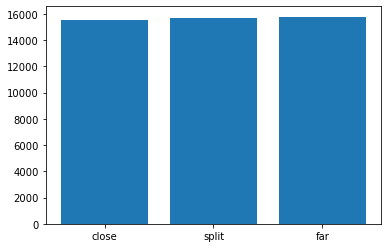

In [150]:
plt.bar(
    np.arange(3),
    height=[len(close_examles), len(split_examles), len(far_examles)],
    tick_label = ['close','split','far']
)

### Number of words used for description

In [130]:
def tokenize_example(content):
    content = content.lower()
    content = re.sub('[%s]' % re.escape(string.punctuation), '', content)
    
    endings = ['ish', 'er', 'est']
    tokens = []
    
    for token in content.split():
        for ending in endings:
            if token.endswith(ending):
                token = re.sub(ending, '', token)
        tokens.append(token)
            
    return [START_SYMBOL] + tokens + [END_SYMBOL]

In [146]:
description_words = dict()
description_words_sorted = dict()

for example in examples:
    words = tokenize_example(example.contents) # use content tokenizer
    description_length = len(words) - 2 # don't count start and end symbols
    
    if description_length in description_words.keys():
        description_words[description_length] += 1
    else:
        description_words[description_length] = 1
        
for key in sorted(description_words):
    description_words_sorted[key] = description_words[key]
        
assert np.sum(list(description_words_sorted.values())) == len(examples)

In [147]:
description_words_sorted

{1: 19160,
 2: 12195,
 3: 4055,
 4: 2872,
 5: 2175,
 6: 1697,
 7: 1218,
 8: 882,
 9: 681,
 10: 495,
 11: 404,
 12: 307,
 13: 241,
 14: 214,
 15: 86,
 16: 52,
 17: 47,
 18: 35,
 19: 31,
 20: 36,
 21: 27,
 22: 17,
 23: 13,
 24: 5,
 25: 12,
 26: 3,
 27: 5,
 28: 5,
 29: 2,
 30: 1,
 31: 1,
 32: 4,
 33: 5,
 34: 1,
 35: 3,
 36: 2,
 37: 1,
 39: 1,
 41: 1,
 44: 1,
 53: 1}

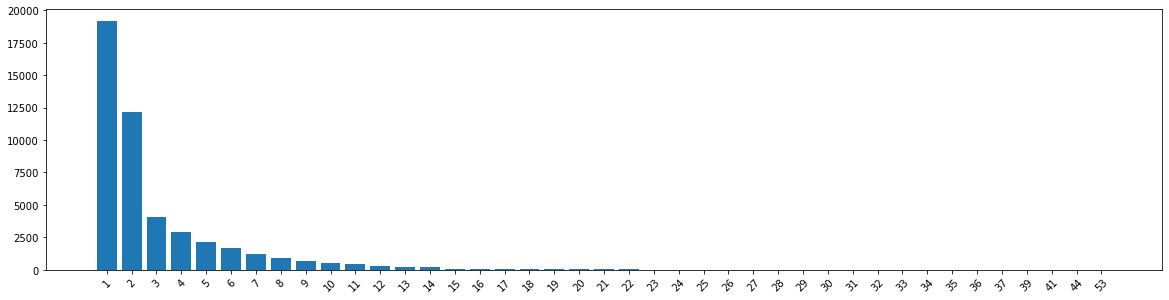

In [168]:
plt.figure(figsize=(20, 4.8))
plt.bar(
    np.arange(len(list(description_words_sorted.keys()))),
    height=list(description_words_sorted.values()),
    tick_label=list(description_words_sorted.keys())
)
plt.xticks(rotation=45)
plt.show()

## Baseline-System

In [ ]:
# baseline system based on assignment 4 (LSTM, GRU)

## Transformers

In [ ]:
# transformers experiments

## Few-Shot-Learning

In [ ]:
# some more experiment with GPT-3 maybe to compare with few-shot-learning